
# UDACITY  -    Advanced land finding


#### Hiep Truong Cong

In [1]:
from CarND_Advanced_Lane_Lines import *
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg

## Read image

In [2]:
img = mpimg.imread('./test_images/straight_lines1.jpg')

# Camera calibration

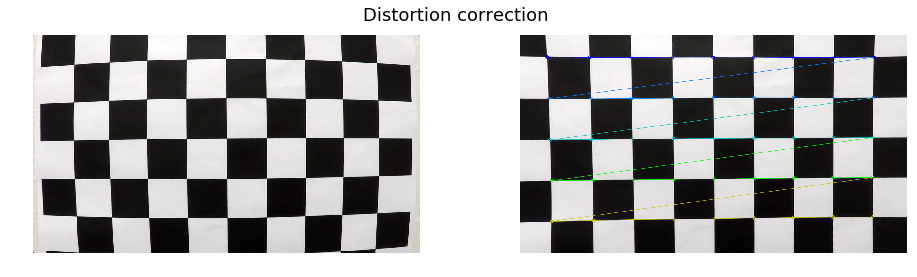

In [3]:
mtx,dist = Perform_Calibration()

# Distortion correction

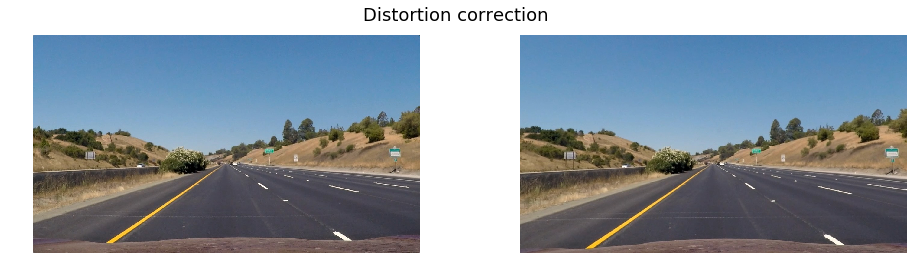

In [5]:
undistorted_img = Undistortion_Demo(img, mtx, dist)

# Color and gradient thresholding

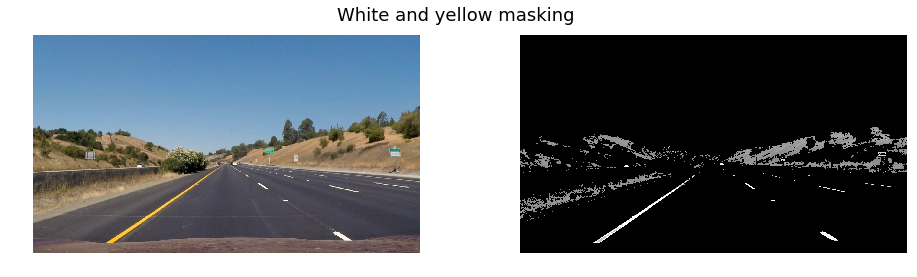

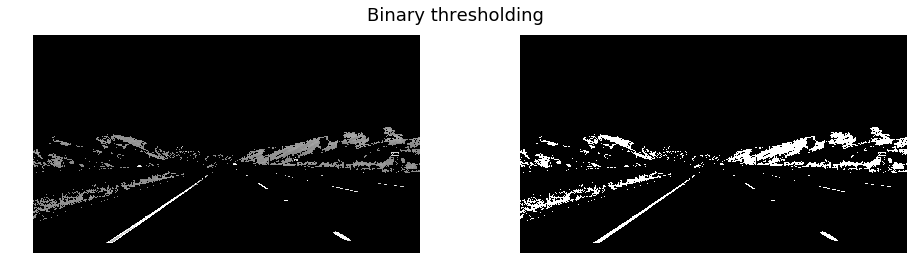

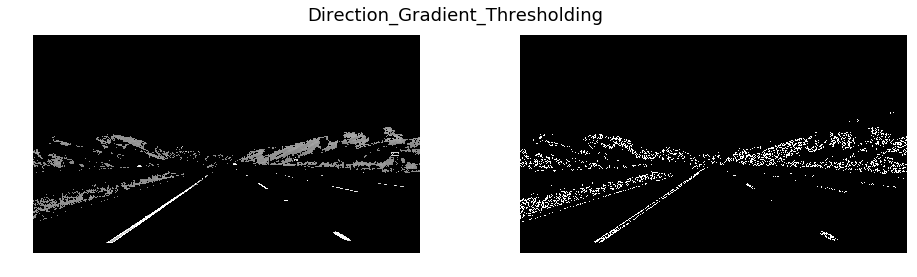

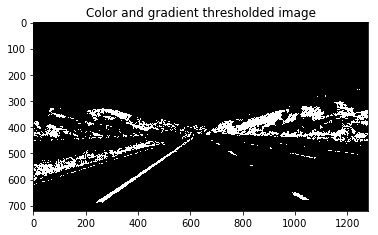

In [6]:
thresholded_img = color_Gradient_Threshold(img, plot_allowed = True)

# Perspective transformation

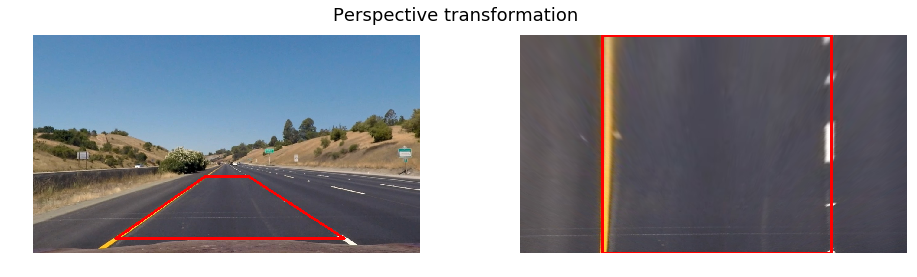

In [7]:
M, Minv = Perspective_Transformation(undistorted_img)

## Pipeline for images

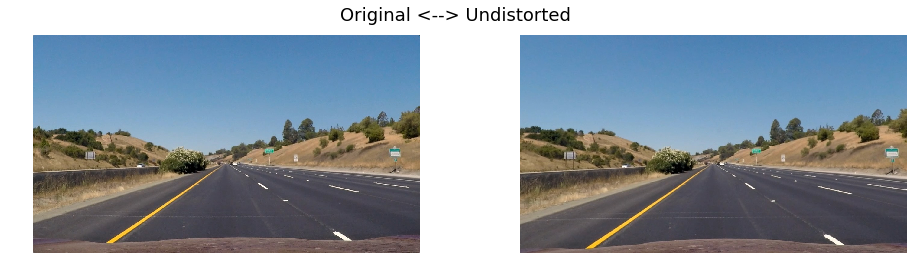

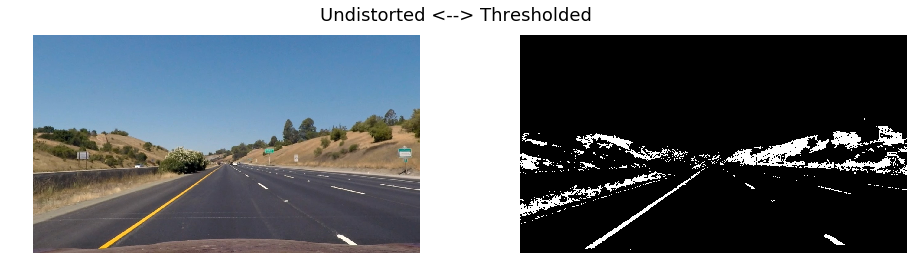

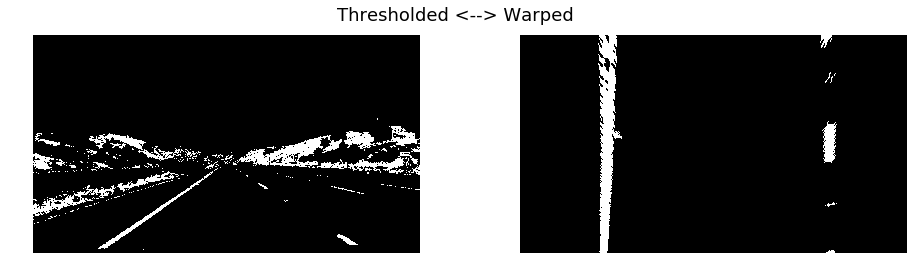

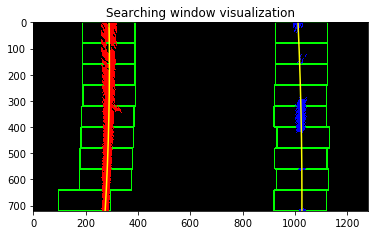

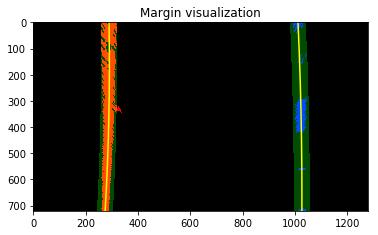

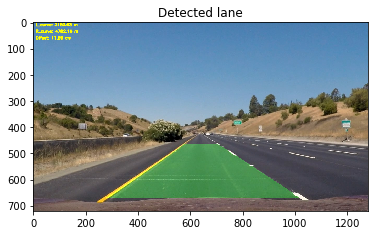

In [8]:
img_p = Pineline_image(img, M, mtx, dist, Minv)
Plot_Images([img_p],1, title = 'Detected lane')

## Pipeline for videos

In [9]:
left_fit = []
right_fit = []
last_left_curverad = 0.0
last_right_curverad = 0.0
last_offset = 0.0
Is_1st_Frame = True
frame_number = 0

def process_image(image):
    global frame_number, left_fit, right_fit, last_left_curverad, last_right_curverad, last_offset, Is_1st_Frame
    left_fit, right_fit, img, Detected, new_left_curverad, new_right_curverad, new_offset = Pineline_video(image, M, Minv,mtx, dist, 
                                                       Is_1st_Frame = Is_1st_Frame,
                                                       left_fit = left_fit,
                                                       right_fit = right_fit,
                                                       last_left_curverad = last_left_curverad,
                                                       last_right_curverad = last_right_curverad,
                                                       last_offset = last_offset)
    img = add_Text_2_img(img, 'frame: ' + str(frame_number), (10,710))
    img = add_Text_2_img(img, 'Hiep Truong', (1150,710))
    frame_number = frame_number + 1
    Is_1st_Frame = not Detected
    last_left_curverad = new_left_curverad
    last_right_curverad = new_right_curverad
    last_offset = new_offset
    return img

def Processing_video(input_video, output_video):
    clip1 = VideoFileClip(input_video)
    white_clip = clip1.fl_image(process_image)
    %time white_clip.write_videofile(output_video, audio=False)

In [10]:
input_project_video = './test_videos/project_video.mp4'
file_name =  input_project_video.replace('./test_videos/', '')
output_project_video = './output_videos/' + file_name

Processing_video(input_project_video, output_project_video)

[MoviePy] >>>> Building video ./output_videos/project_video.mp4
[MoviePy] Writing video ./output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:33<00:00,  6.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video.mp4 

Wall time: 3min 34s


In [10]:
input_challenge_video = './test_videos/challenge_video.mp4'
file_name =  input_challenge_video.replace('./test_videos/', '')
output_challenge_video = './output_videos/' + file_name

Processing_video(input_challenge_video, output_challenge_video)

[MoviePy] >>>> Building video ./output_videos/challenge_video.mp4
[MoviePy] Writing video ./output_videos/challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:24<00:00,  6.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/challenge_video.mp4 

Wall time: 1min 26s


# Results

### Project video

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_project_video))

### Challenge video

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_challenge_video))

## Miscellaneous

In [12]:
# Debugging functions
# Extract frames from a video

frames_to_extract = [i for i in range(990,1044)]
frame_number = 0


input_video = './output_videos/project_video.mp4'
file_name =  input_video.replace('./output_videos/', '')
file_name =  file_name.replace('.mp4', '')

cap = cv2.VideoCapture(input_video)

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
        if frame_number in frames_to_extract:
            file_name_to_write = './extracted/' + file_name + str(frame_number) + '.jpg'
            cv2.imwrite(file_name_to_write, frame)
        frame_number = frame_number + 1
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break  
    else:
        print("cannot read")
        break


cannot read
